In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.optimize import fsolve

## Simulate Full Swiss Model

In [2]:
def sample_full_model1(sigma_nu=0.5):
    # sample tau_theta uniform at random from [0,2]
    tau_theta = np.random.uniform(0, 2)
    # sample tau_lambda uniform at random from [0,2]
    tau_lambda = np.random.uniform(0, 2)
    # sample sigma uniform at random from [0,2]
    sigma = np.random.uniform(0, 2)
    # sample nu_1, nu_2 iid uniform at random from N(0,0.5^2)
    nu = np.random.normal(0, sigma_nu**2, size=2)
    
    theta = []
    lambda_ = []
    y = []
    
    # for i in 1,2
    for i in range(2):
        # sample theta_i from N(nu_j, tau_theta^2)
        theta_i = np.random.normal(0, tau_theta)
        theta.append(theta_i)
        
        # sample lambda_i from N(nu_j, tau_lambda^2)
        lambda_i = np.random.normal(nu[i], tau_lambda)
        lambda_.append(lambda_i)
        
        # sample y_i from N(theta_i + lambda_i, sigma^2)
        y_i = np.random.normal(theta_i + lambda_i, sigma)
        y.append(y_i)    
    
    return theta, y

In [6]:
# return probability each method is correct
def deterministic_correct(thetas, ys):
    if thetas[0] > thetas[1]:
        return ys[0] > ys[1]
    else:
        return ys[1] > ys[0]

def threshold_lottery_correct(thetas, ys, C):
    if np.abs(ys[0] - ys[1]) > C:
        return int(deterministic_correct(thetas, ys))
    else:
        return 0.5

def threshold(thetas, ys, C):
    if np.abs(ys[0] - ys[1]) > C:
        return int(deterministic_correct(thetas, ys))
    else:
        return 1. - int(deterministic_correct(thetas, ys))

In [4]:
Cs=[0, 0.1, 0.5, 1., 2.]

def simulate(n=1000000, sigma_nu=0.5, Cs=Cs):
    r_mean = {C:0 for C in Cs}
    r_var = {C: 0 for C in Cs}
    r_se = {}
    for _ in range(n):
        thetas, ys = sample_full_model1(sigma_nu=sigma_nu)
        for C in Cs:
            r = threshold_lottery_correct(thetas, ys, C)
            r_mean[C] += r
            r_var[C] += r**2

    r_se = {}
    for C in Cs:
        r_mean[C] = r_mean[C] / n
        r_var[C] = ((r_var[C] / n) - r_mean[C]**2)*(n/(n-1))
        r_se[C] = np.sqrt(r_var[C]) / np.sqrt(n)
    
    return r_mean, r_se
    
def plot_results(r_mean, r_se, Cs=Cs, ylim=None):
    x = Cs
    y = [r_mean[C] for C in Cs]
    yerr = [1.96*r_se[C] for C in Cs]

    plt.figure(figsize=(10, 6))
    plt.errorbar(x, y, yerr=yerr, fmt='-o', capsize=5, capthick=2, ecolor='red', 
                 markeredgecolor='black', markerfacecolor='blue')

    plt.xlabel('Threshold for Lottery (0=deterministc)', fontsize=16)
    plt.ylabel('Probability Correct', fontsize=16)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    plt.show()

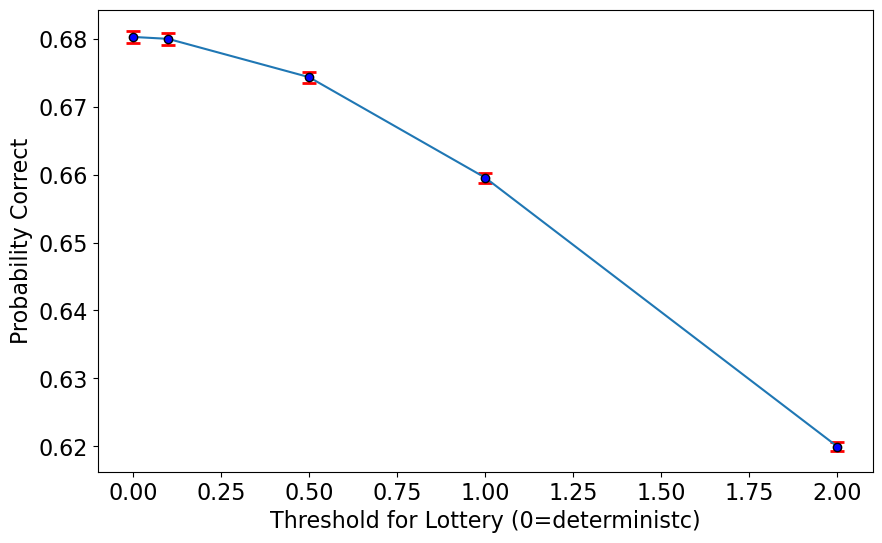

In [5]:
r_mean, r_se = simulate(sigma_nu=0.5)
plot_results(r_mean, r_se)

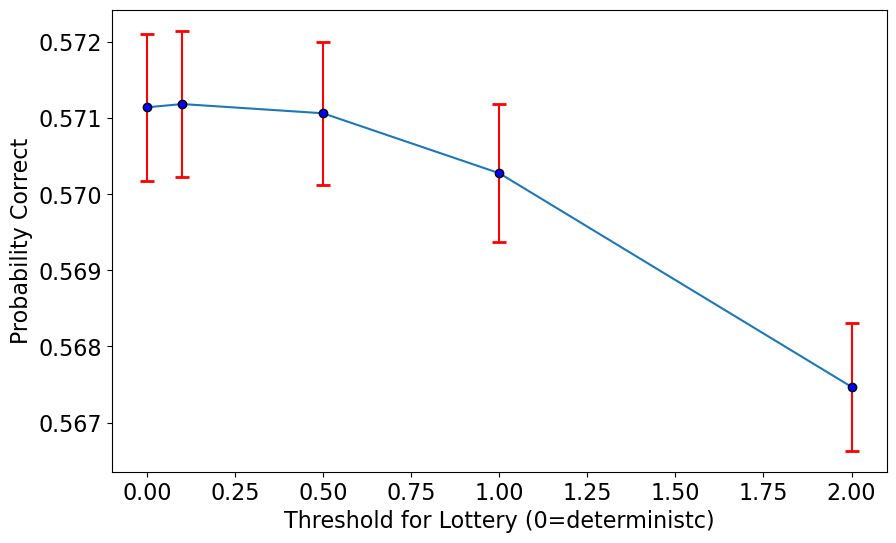

In [6]:
r_mean, r_se = simulate(sigma_nu=2)
plot_results(r_mean, r_se)

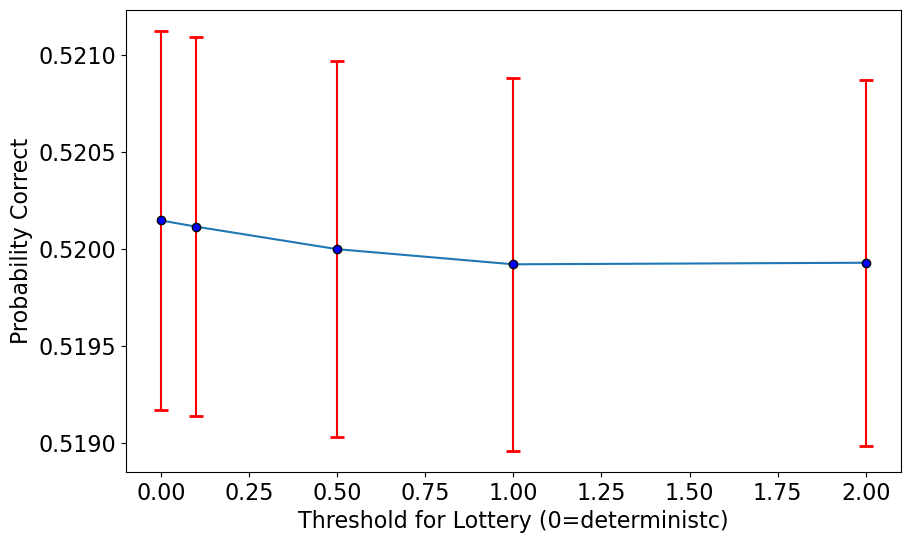

In [7]:
r_mean, r_se = simulate(sigma_nu=4)
plot_results(r_mean, r_se)

## Simulate Model with Fixed Gaps and Fixed Variance

In [8]:
def sample_model2(theta, nu, sigma):
    thetas = np.random.permutation([0, theta])
    nus = np.random.permutation([0, nu])
    lambdas = nus
    ys = thetas + lambdas + np.random.normal(loc=0, scale=sigma, size=2)
    return thetas, ys

In [9]:
# return estimate of expected correct in model 2
def deterministic_exp_correct_model2(theta, nu, sigma):
    tau = np.sqrt(2)*sigma
    return 0.5*(norm.cdf((theta+nu)/tau) + norm.cdf((theta-nu)/tau))

def threshold_lottery_exp_correct_model2(theta, nu, sigma, C):
    tau = np.sqrt(2)*sigma
    return 0.25*(norm.cdf((theta+nu-C)/tau) + norm.cdf((theta+nu+C)/tau)
                 + norm.cdf((theta-nu-C)/tau) + norm.cdf((theta-nu+C)/tau))

def run_sim_model2(theta, nu, sigma, C, iters=50000):
    print(f'======= theta={theta}, nu={nu}, sigma={sigma}, C={C} =======')
    d_exp = deterministic_exp_correct_model2(theta, nu, sigma)
    r_exp = threshold_lottery_exp_correct_model2(theta, nu, sigma, C)
    print('Expected success (theory):')
    print(round(d_exp, 4), round(r_exp, 4))
    
    d = 0
    r = 0
    t = 0
    for _ in range(iters):
        thetas, ys = sample_model2(theta, nu, sigma)
        d += deterministic_correct(thetas, ys)
        r += threshold_lottery_correct(thetas, ys, C)
        t += threshold(thetas, ys, C)

    d = d / iters
    r = r / iters
    t = t / iters
    
    print('Expected success (sims):')
    print(round(d, 4), round(r, 4), round(t, 4))

In [ ]:
# NOTE: review scale of 1-6 expected
theta = 2
nu = 1
sigma = 2.
C = 1

run_sim_model2(theta, nu, sigma, C)

======= theta=2, nu=1, sigma=2.0, C=1 =======
Expected success (theory):
0.7469 0.7355
Expected success (sims):
0.7461 0.7344 0.7227


In [ ]:
# NOTE: review scale of 1-6 expected
theta = 4
nu = 1
sigma = 0.2
C = 3

run_sim_model2(theta, nu, sigma, C)

======= theta=4, nu=1, sigma=0.2, C=3 =======
Expected success (theory):
1.0 0.875
Expected success (sims):
1.0 0.8756 0.7512


In [ ]:
# NOTE: review scale of 1-6 expected
theta = 2
nu = 3
sigma = 0.2
C = 3

run_sim_model2(theta, nu, sigma, C)

======= theta=2, nu=3, sigma=0.2, C=3 =======
Expected success (theory):
0.5001 0.75
Expected success (sims):
0.5027 0.7513 0.9999


In [ ]:
# NOTE: review scale of 1-6 expected
theta = 2
nu = 3
sigma = 0.2
C = 10

run_sim_model2(theta, nu, sigma, C)

======= theta=2, nu=3, sigma=0.2, C=10 =======
Expected success (theory):
0.5001 0.5
Expected success (sims):
0.4968 0.5 0.5032


In [ ]:
# NOTE: review scale of 1-6 expected
theta = 2.5
nu = 3
sigma = 0.2
C = 1

run_sim_model2(theta, nu, sigma, C)

======= theta=2.5, nu=3, sigma=0.2, C=1 =======
Expected success (theory):
0.5193 0.7404
Expected success (sims):
0.5179 0.7403 0.9628


In [ ]:
# NOTE: review scale of 1-6 expected
theta = 2.5
nu = 3
sigma = 0.2
C = 2

run_sim_model2(theta, nu, sigma, C)

======= theta=2.5, nu=3, sigma=0.2, C=2 =======
Expected success (theory):
0.5193 0.75
Expected success (sims):
0.5192 0.7502 0.9812


In [ ]:
# NOTE: review scale of 1-6 expected
theta = 2.5
nu = 3
sigma = 0.2
C = 5

run_sim_model2(theta, nu, sigma, C)

======= theta=2.5, nu=3, sigma=0.2, C=5 =======
Expected success (theory):
0.5193 0.7404
Expected success (sims):
0.5192 0.7397


In [ ]:
# NOTE: review scale of 1-6 expected
theta = 2.5
nu = 3
sigma = 0.2
C = 6

run_sim_model2(theta, nu, sigma, C)

======= theta=2.5, nu=3, sigma=0.2, C=6 =======
Expected success (theory):
0.5193 0.5096
Expected success (sims):
0.5181 0.5097


## Stochastic Quality, Adversarial Miscalibration

In [3]:
def p_err_threshold(lam, T, sigma=1):
    if T < lam:
        return 0.5*(norm.cdf((lam+T)/(sigma*np.sqrt(2))) + norm.cdf((lam-T)/(sigma*np.sqrt(2)))) - 0.5
    else:
        return 0.5*(norm.cdf((lam+T)/(sigma*np.sqrt(2))) - norm.cdf((lam-T)/(sigma*np.sqrt(2))))
    
def p_err_max(lam, sigma=1):
    return norm.cdf((lam)/(np.sqrt(2) * sigma)) - 0.5

# sample T from exponential distribution
def p_err_random_exp_threshold(lam, scale, sigma=1, n_sims=1000):
    Ts = np.random.exponential(scale, size=n_sims)
    errs = [p_err_threshold(lam, T, sigma) for T in Ts]
    m = np.mean(errs) # mean
    s = np.std(errs) / np.sqrt(n_sims) # std error
    return m, s   

# get value of optimal fixed T
def solve_opt_fixed_T(lam, sigma=1):
    def equation(T):
        return p_err_threshold(lam, T, sigma) - p_err_threshold(0, T, sigma)

    # Use fsolve to find the root of the equation
    initial_guess = lam/2  # A reasonable starting point for T
    T_solution = fsolve(equation, initial_guess)[0]

    return T_solution

# sample T from uniform distribution centered around optimal fixed T
def p_err_random_uniform_threshold(lam_max, lam, width, sigma=1, n_sims=1000):
    T_opt = solve_opt_fixed_T(lam_max, sigma)
    Ts = np.random.uniform(T_opt - width/2, T_opt + width/2, size=n_sims)
    errs = [p_err_threshold(lam, T, sigma) for T in Ts]
    m = np.mean(errs) # mean
    s = np.std(errs) / np.sqrt(n_sims) # std error
    return m, s

def get_std_threshold_err(ys, thetas, V):
    S_y = np.sqrt((ys**2).sum())
    if np.abs(ys[0] - ys[1]) > V*S_y:
        return 1. - int(deterministic_correct(ys, thetas))
    else:
        return 0.5

# simulate the probability of error for thresholding with standard deviation threshold  
def p_err_std_threshold_sim(lambdas, V, sigma=1, n_sims=1000):
    l1, l2 = lambdas
    thetas = np.random.normal(0, sigma, size=(n_sims, 2))
    # add l1 to first column and l2 to second column
    ys_A = thetas + np.array([[l1, l2]])
    # add l2 to first column and l1 to second column
    ys_B = thetas + np.array([[l2, l1]])

    errs = [get_std_threshold_err(ys_A[i], thetas[i], V) for i in range(n_sims)] + [get_std_threshold_err(ys_B[i], thetas[i], V) for i in range(n_sims)]
    return np.mean(errs)


In [4]:
def simulate_and_plot_std_threshold(lam):
    sigmas = [0.5, 1., 2.]
    Vs = np.arange(0, 2.1, 0.1)

    # get error of fixed threshold at each sigma
    errs_fixed = {sigma: [p_err_threshold(lam, T, sigma) for T in Vs] for sigma in sigmas}

    errs = {}
    # simulate the probability of error for thresholding with standard deviation threshold
    for sigma in sigmas:
        errs[sigma] = [p_err_std_threshold_sim([0, lam], V, sigma=sigma, n_sims=5000) for V in Vs]

    plt.figure(figsize=(10, 6))
    for sigma in sigmas:
        c = next(plt.gca()._get_lines.prop_cycler)['color']
        # make label \sigma=0.5, \sigma=1, \sigma=2
        l = f"$\\sigma$={sigma}"
        plt.plot(Vs, errs[sigma], label=l, color=c)
        plt.plot(Vs, errs_fixed[sigma], color=c, linestyle='--')
    plt.xlabel('Threshold (V or T)', fontsize=16)
    plt.ylabel('Probability Error', fontsize=16)
    plt.legend(fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.show()

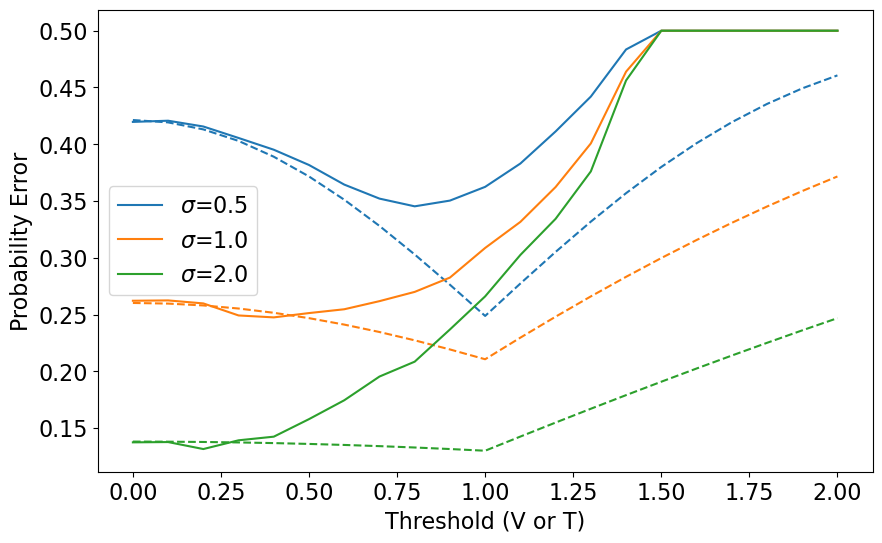

In [42]:
simulate_and_plot_std_threshold(1)

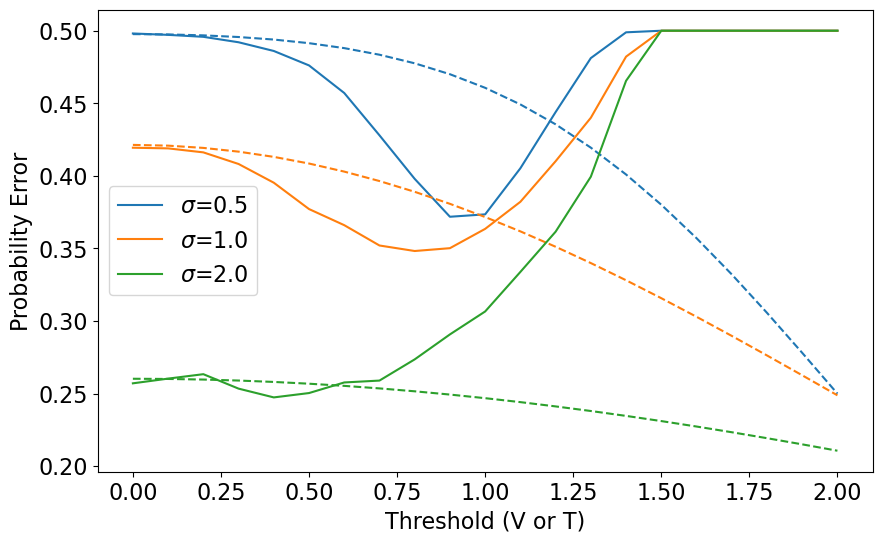

In [43]:
simulate_and_plot_std_threshold(2)

In [19]:
# Fix pi = 2
# Vary sigma between 0.5, 1, 4 and choose optimal
# Choose best of std_threshold, exp, and fixed threshold based on optimal for sigma = 1 to see misspecification

pi = 2
sigmas = [0.5, 1., 2., 4.]

Vs = np.arange(0., 1.2, 0.1)

optVs = {}
uniform_errs = []
exp_errs = []
T_errs = []
std_errs = []

for sigma in sigmas: 
    std_err = None 
    optV = None 

    for V in Vs:
        errsLam = [p_err_std_threshold_sim([0, pi], V, sigma=sigma, n_sims=5000) for V in Vs]
        errs0 = [p_err_std_threshold_sim([0, 0], V, sigma=sigma, n_sims=5000) for V in Vs]
        errsPi = [p_err_std_threshold_sim([pi/2, pi/2], V, sigma=sigma, n_sims=5000) for V in Vs]
        std_err_V = max([errs0, errsLam, errsPi])
        if std_err is None or std_err_V < std_err:
            std_err = std_err_V
            optV = V

    optVs[sigma] = optV

    # optimal using correct sigma
    opt_T = solve_opt_fixed_T(pi, sigma)
    T_err = p_err_threshold(pi , opt_T, sigma)
    exp_err = p_err_random_exp_threshold(pi, opt_T, sigma)
    uniform_err = p_err_random_uniform_threshold(pi, opt_T, (pi-opt_T)/2., sigma)

    uniform_errs += [uniform_err]
    exp_errs += [exp_err]
    T_errs += [T_err]
    std_errs += [std_err]

uniform_errs_mis = []
exp_errs_mis = []
T_errs_mis = []
std_errs_mis = []

for sigma in sigmas:
    # optimal using sigma = 1
    opt_T = solve_opt_fixed_T(pi, 1)
    T_err = p_err_threshold(pi , opt_T, sigma)
    exp_err = p_err_random_exp_threshold(pi, opt_T, sigma)
    uniform_err = p_err_random_uniform_threshold(pi, opt_T, (pi-opt_T)/2., sigma)
    V = optVs[1.]
    errsLam = [p_err_std_threshold_sim([0, pi], V, sigma=sigma, n_sims=5000) for V in Vs]
    errs0 = [p_err_std_threshold_sim([0, 0], V, sigma=sigma, n_sims=5000) for V in Vs]
    errsPi = [p_err_std_threshold_sim([pi/2, pi/2], V, sigma=sigma, n_sims=5000) for V in Vs]
    std_err = max([errs0, errsLam, errsPi])

    uniform_errs_mis += [uniform_err]
    exp_errs_mis += [exp_err]
    T_errs_mis += [T_err]
    std_errs_mis += [std_err]

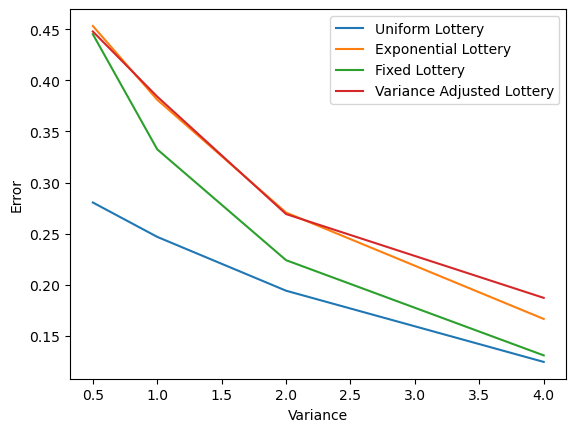

In [29]:
plt.plot(sigmas, [t[0] for t in uniform_errs], label='Uniform Lottery')
plt.plot(sigmas, [t[0] for t in exp_errs], label='Exponential Lottery')
plt.plot(sigmas, T_errs, label='Fixed Lottery')
plt.plot(sigmas, [np.mean(t) for t in std_errs], label='Variance Adjusted Lottery')
plt.ylabel("Error")
plt.xlabel('Standard Deviation of Noise')
plt.legend()
plt.show()

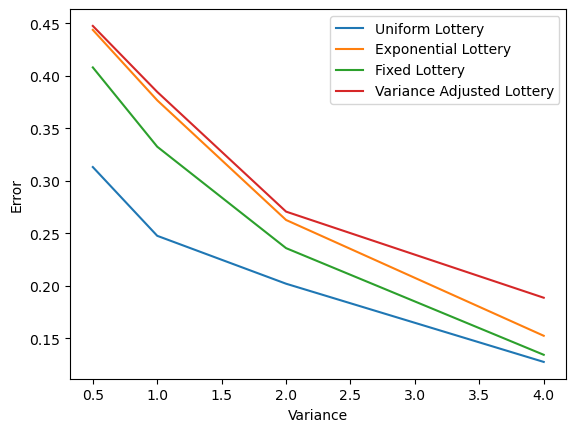

In [30]:
plt.plot(sigmas, [t[0] for t in uniform_errs_mis], label='Uniform Lottery')
plt.plot(sigmas, [t[0] for t in exp_errs_mis], label='Exponential Lottery')
plt.plot(sigmas, T_errs_mis, label='Fixed Lottery')
plt.plot(sigmas, [np.mean(t) for t in std_errs_mis], label='Variance Adjusted Lottery')
plt.ylabel("Error")
plt.xlabel('Variance')
plt.legend()
plt.show()

In [15]:
pi = 2
lams = np.arange(0, pi+0.1, 0.1)
sigma=1.


opt_T = solve_opt_fixed_T(pi, sigma)
print('Opt: ', opt_T)

Ts = [opt_T]

max_err = [p_err_max(lam, sigma) for lam in lams]
threshold_errs = {T: [p_err_threshold(lam, T, sigma) for lam in lams] for T in Ts}

Opt:  1.3634188302745127


In [16]:
# scale = 1. # mean of exponential distribution
# exp_threshold_err_sims1 = [p_err_random_exp_threshold(lam, scale) for lam in lams]
# exp_threshold_err1 = [x[0] for x in exp_threshold_err_sims1]
# exp_threshold_err_se1 = [x[1] for x in exp_threshold_err_sims1]

scale = opt_T # mean of exponential distribution
exp_threshold_err_sims2 = [p_err_random_exp_threshold(lam, scale) for lam in lams]
exp_threshold_err2 = [x[0] for x in exp_threshold_err_sims2]
exp_threshold_err_se2 = [x[1] for x in exp_threshold_err_sims2]

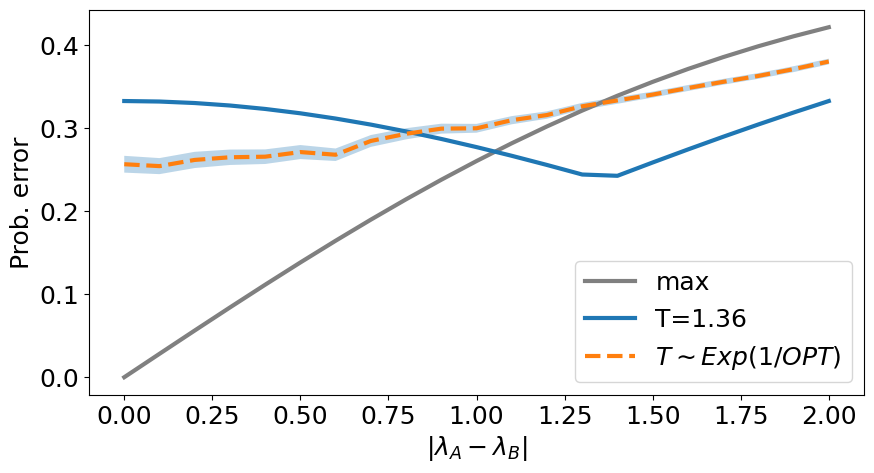

In [18]:
plt.figure(figsize=(10,5))

plt.plot(lams, max_err, label='max', color='grey', lw=3)
for T in Ts:
    plt.plot(lams, threshold_errs[T], label=f'T={round(T,2)}', lw=3)

# plt.plot(lams, exp_threshold_err1, label=r'$T\sim Exp(1)$',  lw=3, linestyle='--')
# # plot error bars for exp threshold
# plt.fill_between(lams, np.array(exp_threshold_err1) - 1.96*np.array(exp_threshold_err_se1),
#                  np.array(exp_threshold_err1) + 1.96*np.array(exp_threshold_err_se1), alpha=0.3)

plt.plot(lams, exp_threshold_err2, label=r'$T\sim Exp(1/OPT)$',  lw=3, linestyle='--')
# plot error bars for exp threshold
plt.fill_between(lams, np.array(exp_threshold_err2) - 1.96*np.array(exp_threshold_err_se2),
                 np.array(exp_threshold_err2) + 1.96*np.array(exp_threshold_err_se2), alpha=0.3)


plt.xlabel(r'$|\lambda_A - \lambda_B|$', fontsize=18)
plt.ylabel('Prob. error', fontsize=18)

plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [ ]:
# fix lambda vary Ts
lam = 2.
Ts = np.arange(0,1.5*lam, 0.1)
threshold_errs_0 = [p_err_threshold(0, T, sigma) for T in Ts]
threshold_errs_lam = [p_err_threshold(lam, T, sigma) for T in Ts]
threshold_errs_lamhalf = [p_err_threshold(lam/2., T, sigma) for T in Ts]


# threshold_errs_exp_0 = [p_err_random_exp_threshold(0, T, n_sims=5000)[0] for T in Ts]
# threshold_errs_exp_lam = [p_err_random_exp_threshold(lam, T, n_sims=5000)[0] for T in Ts]

In [ ]:
threshold_errs_uniform_lam = p_err_random_uniform_threshold(2., 2., 0.4, sigma, n_sims=10000)
threshold_errs_uniform0 = p_err_random_uniform_threshold(2., 0, 0.4, sigma, n_sims=10000)

In [ ]:
threshold_errs_uniform_lam, threshold_errs_uniform0

((0.3322846672814932, 0.00013572326679957004),
 (0.33166873288766785, 0.00020488278784787592))

In [ ]:
opt = solve_opt_fixed_T(lam, sigma)
opt

1.3634188302745127

In [38]:
def compare_uniform(lam_max, sigma):
    opt = solve_opt_fixed_T(lam_max, sigma)

    lams = np.arange(0, lam_max+0.1, 0.1)
    threshold_err_max = [p_err_max(lam, sigma) for lam in lams]
    threshold_err_opt = [p_err_threshold(lam, opt, sigma) for lam in lams]
    threshold_errs_uniform = [p_err_random_uniform_threshold(lam_max, l, lam_max-opt-0.001, sigma, n_sims=10000) for l in lams]

    plt.figure(figsize=(10,5))
    plt.plot(lams, threshold_err_max[:len(lams)], label='Deterministic (Argmax)', color='grey', lw=3)
    plt.plot(lams, threshold_err_opt, label='Fixed Optimal T', lw=3)

    threshold_errs_uniform_mean1 = [x[0] for x in threshold_errs_uniform]
    threshold_errs_uniform_se1 = [x[1] for x in threshold_errs_uniform]

    plt.plot(lams, threshold_errs_uniform_mean1, label='Uniform Random Optimal T',  lw=3, linestyle='--')
    plt.fill_between(lams, np.array(threshold_errs_uniform_se1) - 1.96*np.array(threshold_errs_uniform_se1),
                    np.array(threshold_errs_uniform_se1) + 1.96*np.array(threshold_errs_uniform_se1), alpha=0.3)


    plt.xlabel(r'$|\lambda_A - \lambda_B|$', fontsize=18)
    plt.ylabel('Prob. error', fontsize=18)

    plt.legend(fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()

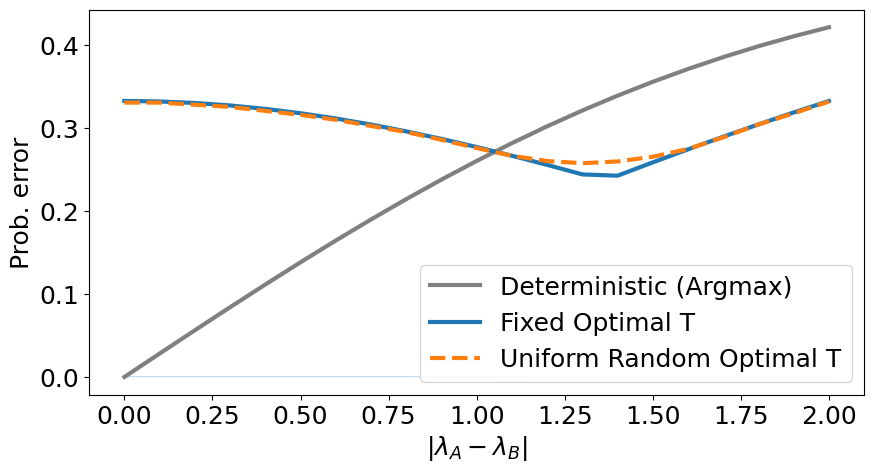

In [168]:
compare_uniform(2., 1.)

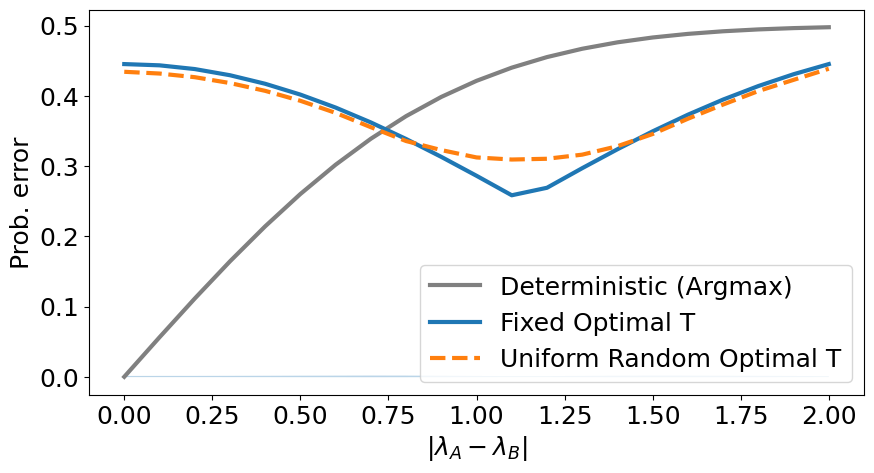

In [39]:
compare_uniform(2, 0.5)

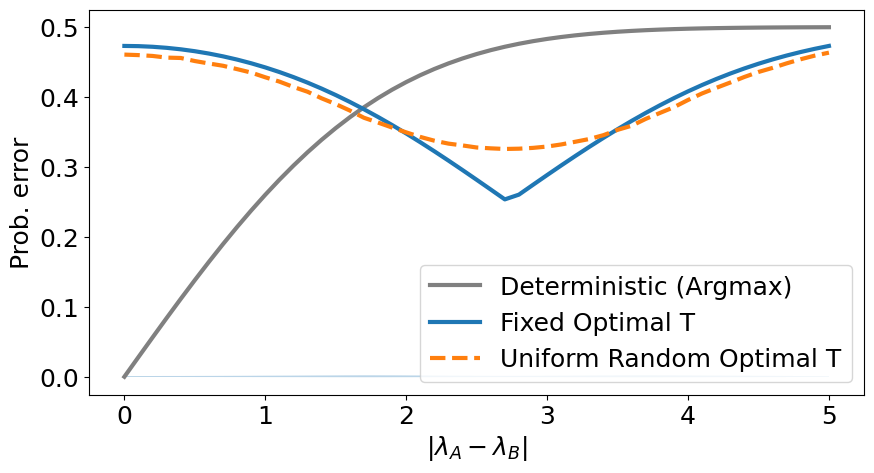

In [170]:
compare_uniform(5., 1.)

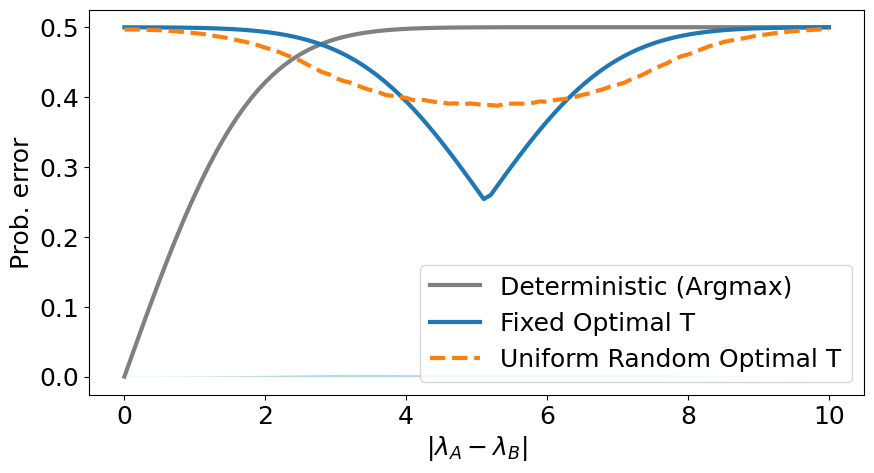

In [171]:
compare_uniform(10., 1.)

In [ ]:
lams = np.arange(0, lam+0.1, 0.1)

threshold_errs_uniform1 = [p_err_random_uniform_threshold(lam, l, lam-opt-0.001, sigma, n_sims=10000) for l in lams]
# threshold_errs_uniform2 = [p_err_random_uniform_threshold(lam, l, (lam-opt-0.001)*0.25, sigma, n_sims=10000) for l in lams]

threshold_errs_opt = [p_err_threshold(lam, opt, sigma) for lam in lams]


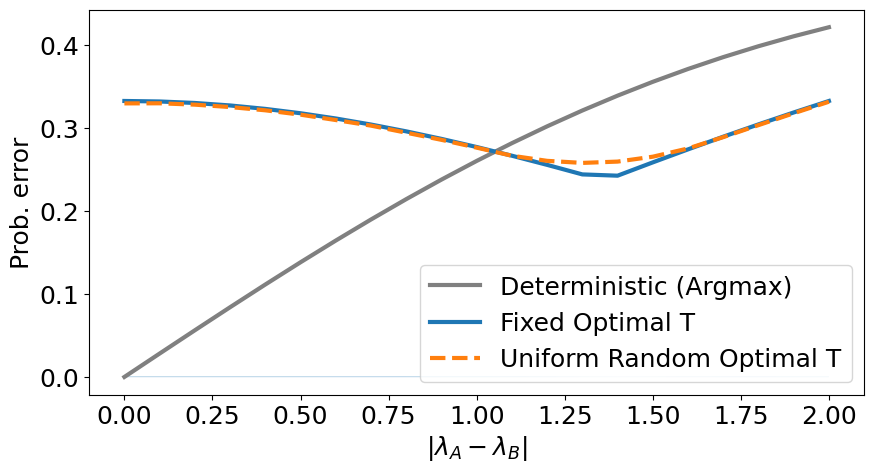

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(lams, max_err[:len(lams)], label='Deterministic (Argmax)', color='grey', lw=3)
plt.plot(lams, threshold_errs_opt, label='Fixed Optimal T', lw=3)

threshold_errs_uniform_mean1 = [x[0] for x in threshold_errs_uniform1]
threshold_errs_uniform_se1 = [x[1] for x in threshold_errs_uniform1]

plt.plot(lams, threshold_errs_uniform_mean1, label='Uniform Random Optimal T',  lw=3, linestyle='--')
plt.fill_between(lams, np.array(threshold_errs_uniform_se1) - 1.96*np.array(threshold_errs_uniform_se1),
                 np.array(threshold_errs_uniform_se1) + 1.96*np.array(threshold_errs_uniform_se1), alpha=0.3)


plt.xlabel(r'$|\lambda_A - \lambda_B|$', fontsize=18)
plt.ylabel('Prob. error', fontsize=18)

plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

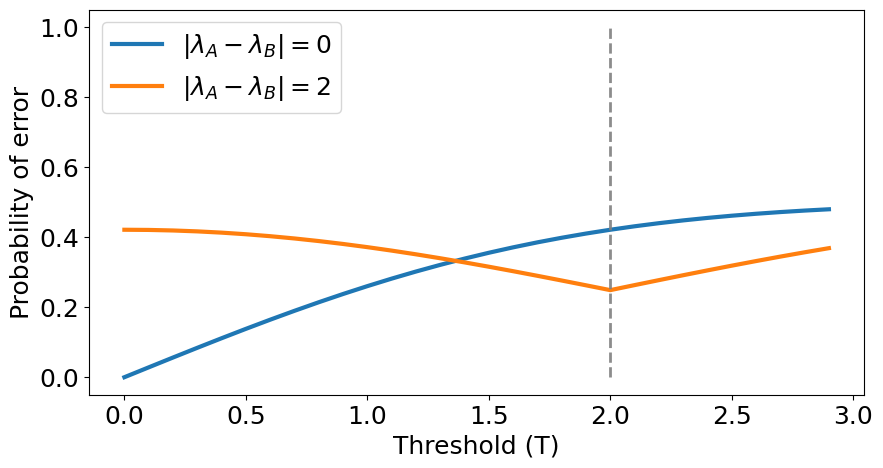

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Ts, threshold_errs_0, label=r'$|\lambda_A - \lambda_B|=$0', lw=3)
plt.plot(Ts, threshold_errs_lam, label=r'$|\lambda_A - \lambda_B|=$'+f'{int(lam)}', lw=3)
# plt.plot(Ts, threshold_errs_lamhalf, label=r'$|\lambda_A - \lambda_B|=$'+f'{int(lam/2.)}', lw=3)
plt.vlines(lam, 0, 1, color='grey', linestyle='--', lw=2, alpha=0.9)

# plt.plot(Ts, threshold_errs_exp_0, label=r'Exp. Random, $\lambda=0$', lw=3, ls='--')
# plt.plot(Ts, threshold_errs_exp_lam, label=r'Exp. Random, $|\lambda_A - \lambda_B|=$'+f'{int(lam)}', lw=3, ls='--')


plt.xlabel(r'Threshold (T)', fontsize=18)
plt.ylabel('Probability of error', fontsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [ ]:
threshold_errs_uniform = [p_err_random_uniform_threshold(2., 2., 0.4, sigma, n_sims=10000)]
threshold_errs_uniform0 = p_err_random_uniform_threshold(2., 0, 0.4, sigma, n_sims=10000)

1.0258988464804033

In [42]:
# worst case error of threshold lottery is at either lambda = 0 or lambda = lambda_max
def worst_p_err_threshold(lambda_max, T, sigma=1):
    return max(p_err_threshold(lambda_max, T, sigma), p_err_threshold(0, T, sigma))

# fix sigma at 1, use optimal fixed T for lambda = 1, vary true lambda_max
def simulate_lambda_sensitivity(lambda_max, lam_range, sigma=1):
    opt = solve_opt_fixed_T(lambda_max, sigma)
    lams = np.arange(0, lam_range+0.1, 0.1)

    errs = [worst_p_err_threshold(lam, opt, sigma) for lam in lams]
    opt_errs = [worst_p_err_threshold(lam, solve_opt_fixed_T(lam, sigma), sigma) for lam in lams]

    return [e - o for e, o in zip(errs, opt_errs)]

# fix sigma at 1, use optimal fixed T for lambda = 1, vary true lambda_max
def simulate_sigma_sensitivity(sigma, sigma_range, lambda_max=1):
    opt = solve_opt_fixed_T(lambda_max, sigma)
    sigmas = np.arange(0.5, sigma_range+0.1, 0.1)

    errs = [worst_p_err_threshold(lambda_max, opt, s) for s in sigmas]
    opt_errs = [worst_p_err_threshold(lambda_max, solve_opt_fixed_T(lambda_max, s), s) for s in sigmas]

    return [e - o for e, o in zip(errs, opt_errs)]

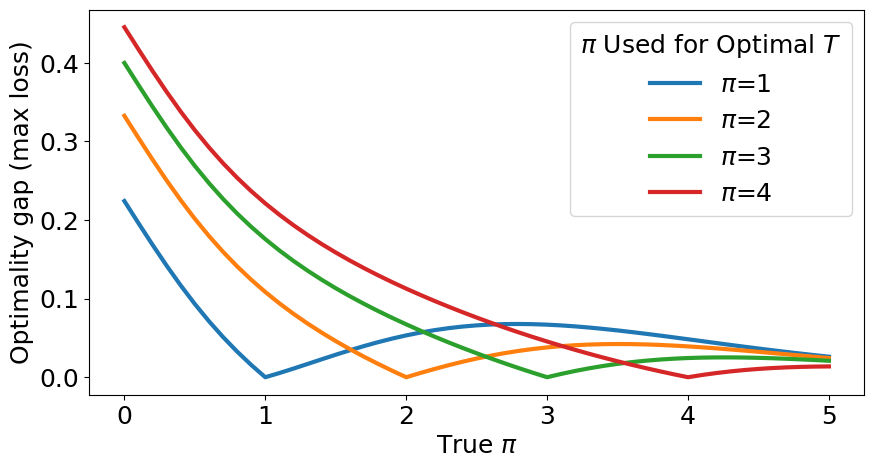

In [44]:
lam_range = 5

lam_opts = [1,2,3,4]

plt.figure(figsize=(10,5))
for l in lam_opts:
    plt.plot(np.arange(0, lam_range+0.1, 0.1), simulate_lambda_sensitivity(l, lam_range), label=f'$\pi$={l}', lw=3)

plt.xlabel(r'True $\pi$', fontsize=18)
plt.ylabel('Optimality gap (max loss)', fontsize=18)
plt.legend(fontsize=18, title=r'$\pi$ Used for Optimal $T$', title_fontsize='18')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [26]:
o4 = solve_opt_fixed_T(1, 4)
o1 = solve_opt_fixed_T(1, 1)
o1, o4

(0.8415111048183914, 0.9849581667346878)

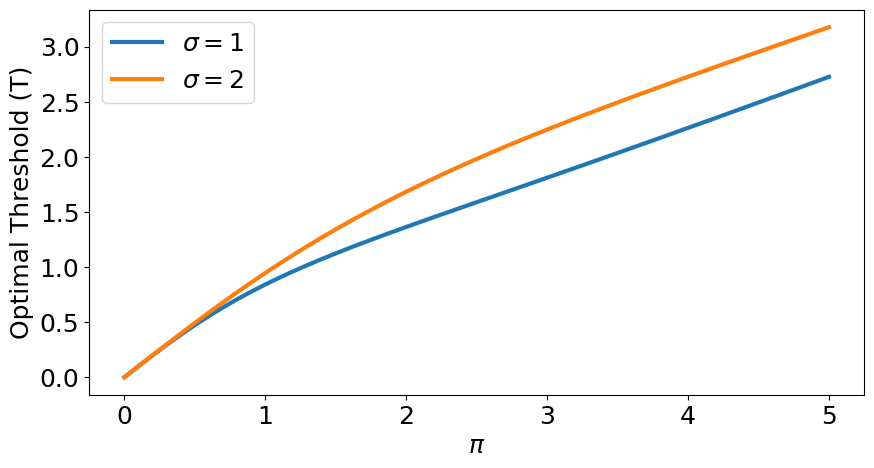

In [46]:
# plot opt T as function of lambda_max
plt.figure(figsize=(10,5))

opts1 = [solve_opt_fixed_T(l, 1) for l in np.arange(0, 5.1, 0.1)]
opts2 = [solve_opt_fixed_T(l, 2) for l in np.arange(0, 5.1, 0.1)]

plt.plot(np.arange(0, 5.1, 0.1), opts1, label=r'$\sigma=1$', lw=3)
plt.plot(np.arange(0, 5.1, 0.1), opts2, label=r'$\sigma=2$', lw=3)

plt.xlabel(r'$\pi$', fontsize=18)
plt.ylabel('Optimal Threshold (T)', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

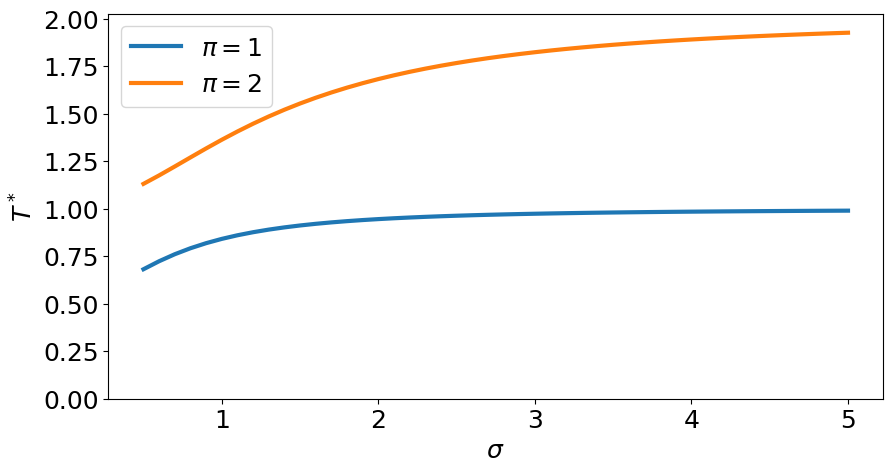

In [41]:
# plot opt T for fixed lambda as a function of sigma
sigmas = np.arange(0.5, 5.1, 0.1)
opts1 = [solve_opt_fixed_T(1, s) for s in sigmas]
opts2 = [solve_opt_fixed_T(2, s) for s in sigmas]

plt.figure(figsize=(10,5))
plt.plot(sigmas, opts1, label=r'$\pi=1$', lw=3)
plt.plot(sigmas, opts2, label=r'$\pi=2$', lw=3)

plt.xlabel(r'$\sigma$', fontsize=18)
plt.ylabel(r'$T^*$', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# make y axis start at 0
plt.ylim(0, max(opts2)+0.1)
plt.show()

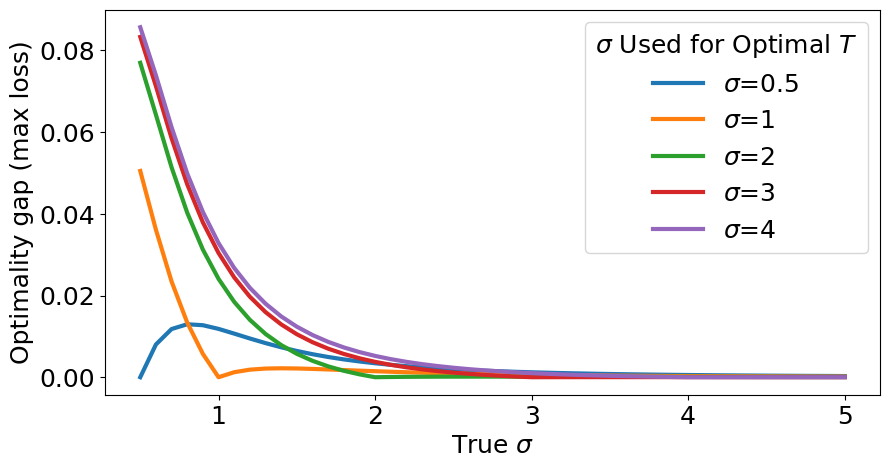

In [47]:
sigma_range = 5

sigma_opts = [0.5, 1, 2, 3, 4]

plt.figure(figsize=(10,5))
for s in sigma_opts:
    plt.plot(np.arange(0.5, sigma_range+0.1, 0.1), simulate_sigma_sensitivity(s, sigma_range), label=f'$\sigma$={s}', lw=3)

plt.xlabel(r'True $\sigma$', fontsize=18)
plt.ylabel('Optimality gap (max loss)', fontsize=18)
plt.legend(fontsize=18, title=r'$\sigma$ Used for Optimal $T$', title_fontsize='18')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


# Comparison of Estimators in Different  Models of Miscalibration

In [16]:
# Simulate in Swiss NSF Bayesian model 

Ts = np.arange(0, 3, 0.1)
iters = 100000

det_correct, thresh_correct, exp_correct, uniform_correct = [], [], [], []

for i in range(iters):
    thetas, ys = sample_full_model1()
    det_correct_i, thresh_correct_i, exp_correct_i, uniform_correct_i = [], [], [], []
    for T in Ts:
        det_correct_i.append(deterministic_correct(thetas, ys))
        thresh_correct_i.append(threshold_lottery_correct(thetas, ys, T))
        T_exp = np.random.exponential(T)
        exp_correct_i.append(threshold_lottery_correct(thetas, ys, T_exp))
        # get uniform from T - 0.5 to T + 0.5 or [0, to 2T]
        if T < 0.5: 
            T_uniform = np.random.uniform(0, 2*T)
        else:
            T_uniform = np.random.uniform(T - 0.5, T + 0.5)
        uniform_correct_i.append(threshold_lottery_correct(thetas, ys, T_uniform)) 
    det_correct.append(det_correct_i)
    thresh_correct.append(thresh_correct_i)
    exp_correct.append(exp_correct_i)
    uniform_correct.append(uniform_correct_i)

det_err = 1. - np.array(det_correct)
thresh_err = 1. - np.array(thresh_correct)
exp_cor = 1. - np.array(exp_correct)
uniform_err = 1. - np.array(uniform_correct)

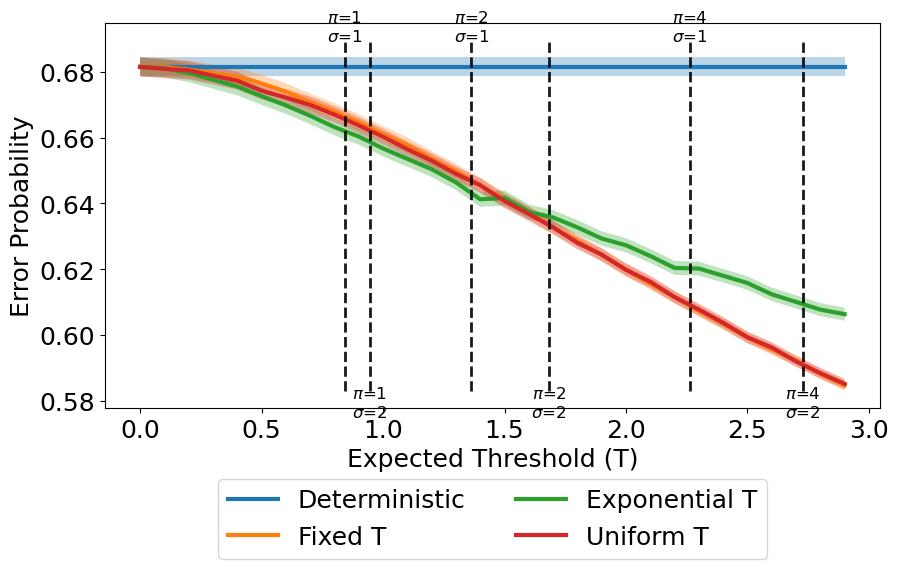

In [42]:
# plot the mean and std error of the probability of correct for each threshold
plt.figure(figsize=(10,5))
plt.plot(Ts, np.mean(det_correct, axis=0), label='Deterministic', lw=3)
plt.plot(Ts, np.mean(thresh_correct, axis=0), label='Fixed T', lw=3)
plt.plot(Ts, np.mean(exp_correct, axis=0), label='Exponential T', lw=3)
plt.plot(Ts, np.mean(uniform_correct, axis=0), label='Uniform T', lw=3)

plt.fill_between(Ts, np.mean(det_correct, axis=0) - 1.96*np.std(det_correct, axis=0)/np.sqrt(iters),
                    np.mean(det_correct, axis=0) + 1.96*np.std(det_correct, axis=0)/np.sqrt(iters), alpha=0.3) 
plt.fill_between(Ts, np.mean(thresh_correct, axis=0) - 1.96*np.std(thresh_correct, axis=0)/np.sqrt(iters), 
                    np.mean(thresh_correct, axis=0) + 1.96*np.std(thresh_correct, axis=0)/np.sqrt(iters), alpha=0.3)
plt.fill_between(Ts, np.mean(exp_correct, axis=0) - 1.96*np.std(exp_correct, axis=0)/np.sqrt(iters),
                    np.mean(exp_correct, axis=0) + 1.96*np.std(exp_correct, axis=0)/np.sqrt(iters), alpha=0.3)
plt.fill_between(Ts, np.mean(uniform_correct, axis=0) - 1.96*np.std(uniform_correct, axis=0)/np.sqrt(iters),
                    np.mean(uniform_correct, axis=0) + 1.96*np.std(uniform_correct, axis=0)/np.sqrt(iters), alpha=0.3)


lims = plt.ylim()
# pi = 2, sigma = 1
for pi, sigma in [(1, 1), (2,1), (4, 1), (1,2), (2,2), (4,2)]:
    opt = solve_opt_fixed_T(pi, sigma)
    plt.vlines(opt, lims[0]+0.005, lims[1], color='black', linestyle='--', lw=2, alpha=0.9)
    plt.text(opt, lims[1] if sigma == 1 else lims[0] - 0.003, f'$\pi$={pi}\n$\sigma$={sigma}', fontsize=12, color='black', ha='center')
opt = solve_opt_fixed_T(2)

plt.xlabel(r'Expected Threshold (T)', fontsize=18)
plt.ylabel('Error Probability', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# put legend below plot and make 2 columns 
plt.legend(fontsize=18, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

In [ ]:
# Run in their model chooseing Pi and Lamba based on thier model params and vary their variance params
# Write to Rachel for their code

## Simulate Model with Noise

In [8]:
pi = 2
sigma_theta = 1
sigma_eps = 1

def sample_model_w_error(pi, sigma_theta, sigma_eps, n_samples=1):
    # sample from normal distribution
    thetas = np.random.normal(0, sigma_theta, (n_samples, 2))
    epsilons = np.random.normal(0, sigma_eps, (n_samples, 2))
    lambdas = np.array([0, pi])
    ys = thetas + lambdas + epsilons
    return thetas, ys

def deterministic_correct(thetas, ys):
    theta_diff = thetas[:, 0] - thetas[:, 1]
    y_diff = ys[:, 0] - ys[:, 1]
    correct = (theta_diff > 0) == (y_diff > 0)
    return correct

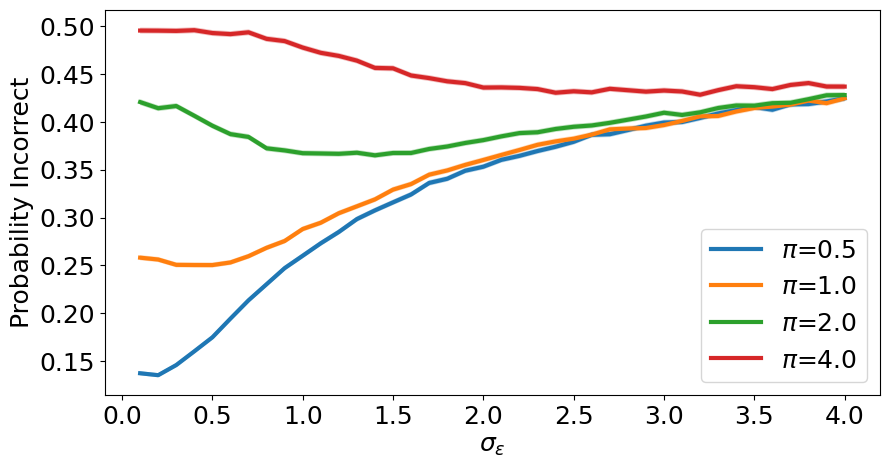

In [26]:
sigma_theta = 1.
pis = [0.5, 1., 2., 4.]

n_sims = 100000

res = {}
for pi in pis:
    res[pi] = []
    for sigma_eps in np.arange(0.1, 4.1, 0.1):
        thetas, ys = sample_model_w_error(pi, sigma_theta, sigma_eps, n_samples=n_sims)
        prop_incorrect = 1.-np.mean(deterministic_correct(thetas, ys))
        res[pi].append(prop_incorrect)
    res[pi] = np.array(res[pi])
plt.figure(figsize=(10,5))
for pi in pis:
    plt.plot(np.arange(0.1, 4.1, 0.1), res[pi], label=f'$\pi$={pi}', lw=3)
    # add binomial error bars as shading around line
    plt.fill_between(np.arange(0.1, 4.1, 0.1), res[pi] - 1.96*np.sqrt(res[pi]*(1-res[pi])/n_sims), 
                     res[pi] + 1.96*np.sqrt(res[pi]*(1-res[pi])/n_sims), alpha=0.3)
plt.xlabel(r'$\sigma_{\epsilon}$', fontsize=18)
plt.ylabel('Probability Incorrect', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


## Simulate Bias Model

In [ ]:
# Sample instance of scores using uniform distribution for true qualities
def sample_uniform_instance(alpha, beta, n=1000):
    A = np.sort(np.random.uniform(0, 1, n))[::-1]
    A_scores = A 
    B = np.sort(np.random.uniform(0, 1, int(n*alpha)))[::-1]
    B_scores = B * beta
    # return soted true qualities and reported scores (after bias application)
    return A, B, A_scores, B_scores

# Sample instance of scores using pareto distribution for true qualities
def sample_pareto_instance(alpha, beta, delta, n=1000):
    A = np.sort(np.random.pareto(1+delta, n))[::-1]
    A_scores = A 
    B = np.sort(np.random.pareto(1+delta, int(n*alpha)))[::-1]
    B_scores = B * beta
    # return soted true qualities and reported scores (after bias application)
    return A, B, A_scores, B_scores

# Get top k candidates from A and B
def apply_top(A_scores, B_scores, k=2):
    # take k largest from A and B combined
    combined = np.concatenate([A_scores, B_scores])
    # get indices of k largest
    topk = np.argsort(combined)[::-1][:k]
    # get A indices and B indices from top k
    selected_A = topk[topk < len(A_scores)]
    selected_B = topk[topk >= len(A_scores)] - len(A_scores)
    return selected_A, selected_B

# Use rooney rule to select top k (replacing up to 1 candidate from A with top candidate from B)
def apply_rooney(A_scores, B_scores, k=2):
    # take k largest from A and B combined
    combined = np.concatenate([A_scores, B_scores])
    # get indices of k largest
    topk = np.argsort(combined)[::-1][:k]
    # if none of B indices are in the top k, replace the smallest of the top k with the largest of B
    if np.all(topk < len(A_scores)):
        topk[-1] = len(A_scores)
    # get A indices and B indices from top k
    selected_A = topk[topk < len(A_scores)]
    selected_B = topk[topk >= len(A_scores)] - len(A_scores)
    return selected_A, selected_B

# Take 1 based on top score and 2 based on uniform sample from ranks 2 to r
def apply_rank_lottery(A_scores, B_scores, r):
    combined = np.concatenate([A_scores, B_scores])
    top1 = np.argsort(combined)[::-1][0]
    # sample from top 2 to r
    i_rand = np.random.randint(1, r)
    top2 = np.argsort(combined)[::-1][i_rand]
    top = np.array([top1, top2])
    # get A indices and B indices from top k
    selected_A = top[top < len(A_scores)]
    selected_B = top[top >= len(A_scores)] - len(A_scores)
    return selected_A, selected_B

In [ ]:
def run_simulations(alpha, beta, delta, rs, n=1000, n_sims=10000):

    def run_sim(alpha, beta, delta, rs, n):
        if delta is None: 
            A, B, A_scores, B_scores = sample_uniform_instance(alpha, beta, n)
        else:
            A, B, A_scores, B_scores = sample_pareto_instance(alpha, beta, delta, n)

        q = {}
        n_B = {}

        s_A_top, s_B_top = apply_top(A_scores, B_scores)
        q['top'] = sum(A[s_A_top]) + sum(B[s_B_top])
        n_B['top'] = len(s_B_top)

        s_A_rooney, s_B_rooney = apply_rooney(A_scores, B_scores) 
        q['rooney'] = sum(A[s_A_rooney]) + sum(B[s_B_rooney])
        n_B['rooney'] = len(s_B_rooney)

        for r in rs:
            s_A_lottery, s_B_lottery = apply_rank_lottery(A_scores, B_scores, r)
            q['lottery' + str(r)] = sum(A[s_A_lottery]) + sum(B[s_B_lottery])
            n_B['lottery' + str(r)] = len(s_B_lottery)

        return q, n_B
    
    qs = []
    n_Bs = []
    for _ in range(n_sims):
        q, n_B = run_sim(alpha, beta, delta, rs, n)
        qs.append(q)
        n_Bs.append(n_B)
    d = pd.concat((pd.DataFrame(qs).mean(), pd.DataFrame(n_Bs).mean()), axis=1)
    d.columns = ['quality', 'num_B']
    return d

### Uniform Quality

In [ ]:
lotteries = [5, 10, 100, 500]
alpha = 0.5

In [ ]:
run_simulations(0.5, 0.95, None, [5, 10, 100, 500])

,quality,num_B
top,1.996987,0.0000
rooney,1.996950,1.0000
lottery5,1.995487,0.0000
lottery10,1.993033,0.0000
lottery100,1.961135,0.1774
lottery500,1.832979,0.3143


In [ ]:
run_simulations(0.5, 0.5, None, [5, 10, 100, 500])

,quality,num_B
top,1.996973,0.0000
rooney,1.996996,1.0000
lottery5,1.995447,0.0000
lottery10,1.992923,0.0000
lottery100,1.948022,0.0000
lottery500,1.750283,0.0074


### Pareto Quality

In [ ]:
run_simulations(0.5, 0.95, 0, [5, 10, 100, 500])

,quality,num_B
top,53162.456822,0.6376
rooney,52731.066838,1.1027
lottery5,52469.803712,0.6390
lottery10,52160.317888,0.6421
lottery100,51787.130052,0.6330
lottery500,51732.407564,0.6421


In [ ]:
run_simulations(0.5, 0.5, 0, [5, 10, 100, 500])

,quality,num_B
top,18641.375897,0.3908
rooney,18256.676221,1.0370
lottery5,17931.564144,0.3897
lottery10,17651.236969,0.3986
lottery100,17258.862583,0.3991
lottery500,17201.347564,0.4283


In [ ]:
run_simulations(1, 0.5, 0, [5, 10, 100, 500])

,quality,num_B
top,31251.735569,0.6526
rooney,31001.640020,1.1049
lottery5,30297.441636,0.6559
lottery10,29898.333704,0.6561
lottery100,29369.482519,0.6725
lottery500,29299.283940,0.6924


# TODO: use much larger number of selections (take $k > \beta$)